## TPE Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,HipsSumVariancebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,0,81.3479,2,20.0,NaN,158.27,0.63,218.30,28.37,714.92,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,546.93,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,689.44,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,622.01,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,1,73.9726,2,24.0,0.11,233.02,0.48,229.88,39.46,686.51,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

X_train.shape, X_test.shape

((366, 22), (158, 22))

In [4]:
imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(),
    random_state=42,
)

imputer_nonLin.fit(X_train)
X_train_missForest = imputer_nonLin.transform(X_train)
X_test_missForest = imputer_nonLin.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [5]:
X_train_missForest_t = pd.DataFrame(
    X_train_missForest, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_missForest_t = pd.DataFrame(
    X_test_missForest, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [6]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_missForest_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [7]:
X_train_t = pipe.transform(X_train_missForest_t)
X_test_t = pipe.transform(X_test_missForest_t)

X_train_t.shape, X_test_t.shape

((366, 22), (158, 22))

In [ ]:
# Store selected feature names before transformation
sel = ['Ageatscreening', 'MMSE0m', 'HipsContrastbaseline',
       'HipsEntropybaseline', 'ERCsContrastbaseline', 'ERCsCorelationbaseline',
       'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'HipposcampusVolumebaseline']

In [9]:
# Store selected feature names before transformation
selected_features = [col for col in sel if col in X_train_t.columns]
selected_features

['Ageatscreening',
 'MMSE0m',
 'HipsContrastbaseline',
 'HipsEntropybaseline',
 'ERCsContrastbaseline',
 'ERCsCorelationbaseline',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline',
 'HipposcampusVolumebaseline']

In [10]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((366, 9), (158, 9))

## TPE

In [11]:
scaler = StandardScaler()
X_train_t = scaler.fit_transform(X_train_t)
X_test_t = scaler.transform(X_test_t)

In [12]:
def objective(trial):
        
    skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
    )
    
    C = trial.suggest_float('C', 1e-3, 100, log=True)
    tol = trial.suggest_float('tol', 1e-6, 1e-2, log=True)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])
    max_iter = trial.suggest_int('max_iter', 300, 500)
    
    model = LogisticRegression(C=C,
                       tol=tol,
                       class_weight="balanced",
                       solver=solver,
                       max_iter=max_iter,
                       random_state=42)

    score = cross_val_score(model, X_train_t, y_train, scoring="balanced_accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [13]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=20)

[I 2025-06-24 20:30:42,798] A new study created in memory with name: no-name-b57ed0e7-c2a5-49f8-a88a-58f0d6d28f3b
[I 2025-06-24 20:30:43,265] Trial 0 finished with value: 0.7328001628001628 and parameters: {'C': 0.031647728689044544, 'tol': 5.049464380212143e-06, 'solver': 'newton-cholesky', 'max_iter': 312}. Best is trial 0 with value: 0.7328001628001628.
[I 2025-06-24 20:30:43,412] Trial 1 finished with value: 0.7522832722832723 and parameters: {'C': 1.0267701483788607, 'tol': 0.004885616379659249, 'solver': 'lbfgs', 'max_iter': 477}. Best is trial 1 with value: 0.7522832722832723.
[I 2025-06-24 20:30:43,492] Trial 2 finished with value: 0.7522832722832723 and parameters: {'C': 14.51171629790255, 'tol': 0.0021836525888377636, 'solver': 'lbfgs', 'max_iter': 457}. Best is trial 1 with value: 0.7522832722832723.
[I 2025-06-24 20:30:43,609] Trial 3 finished with value: 0.7499023199023199 and parameters: {'C': 49.193938635732536, 'tol': 1.420840999463375e-05, 'solver': 'lbfgs', 'max_iter'

In [14]:
study.best_params

{'C': 0.18751437186365183,
 'tol': 0.00018067941080463672,
 'solver': 'lbfgs',
 'max_iter': 423}

In [15]:
study.best_value

0.7611477411477411

In [16]:
r = study.trials_dataframe()

r.head()

,number,value,datetime_start,datetime_complete,duration,params_C,params_max_iter,params_solver,params_tol,state
0,0,0.732800,2025-06-24 20:30:42.800206,2025-06-24 20:30:43.265877,0 days 00:00:00.465671,0.031648,312,newton-cholesky,0.000005,COMPLETE
1,1,0.752283,2025-06-24 20:30:43.276179,2025-06-24 20:30:43.412472,0 days 00:00:00.136293,1.026770,477,lbfgs,0.004886,COMPLETE
2,2,0.752283,2025-06-24 20:30:43.412820,2025-06-24 20:30:43.492873,0 days 00:00:00.080053,14.511716,457,lbfgs,0.002184,COMPLETE
3,3,0.749902,2025-06-24 20:30:43.492873,2025-06-24 20:30:43.609508,0 days 00:00:00.116635,49.193939,346,lbfgs,0.000014,COMPLETE
4,4,0.749902,2025-06-24 20:30:43.618024,2025-06-24 20:30:43.779737,0 days 00:00:00.161713,1.423943,384,sag,0.000012,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_11524\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


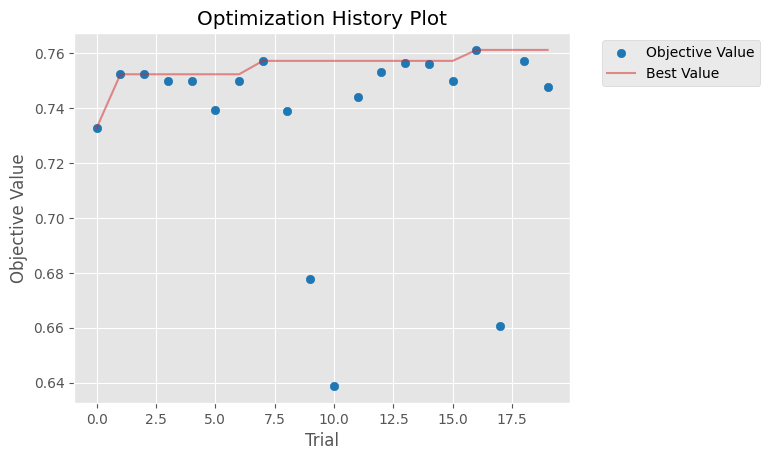

In [17]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_11524\924295173.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='C', ylabel='Objective Value'>,
       <Axes: xlabel='max_iter'>, <Axes: xlabel='solver'>,
       <Axes: xlabel='tol'>], dtype=object)

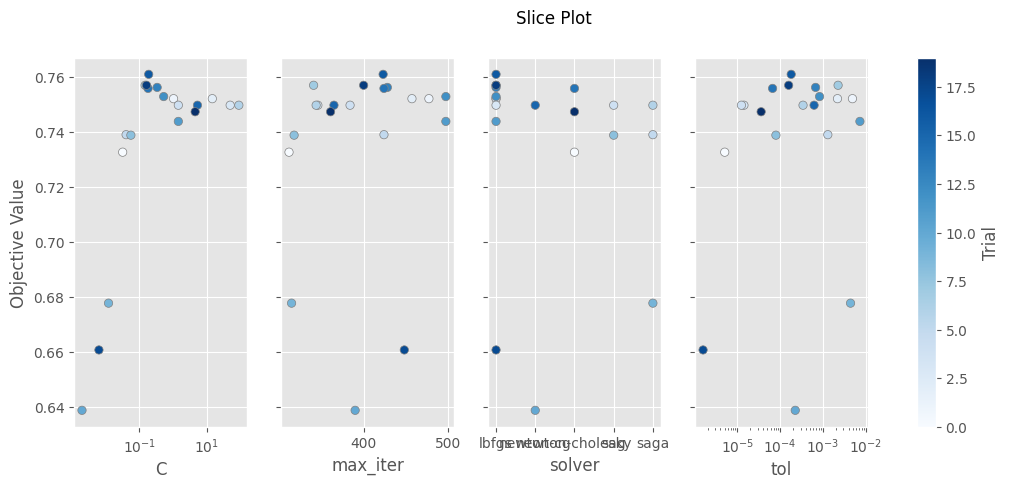

In [18]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["C", "solver", "tol", "max_iter"],
)

C:\Users\steve\AppData\Local\Temp\ipykernel_11524\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

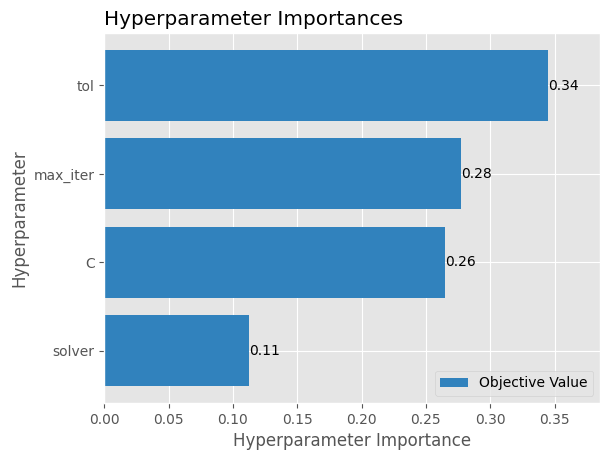

In [19]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_11524\1937692550.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

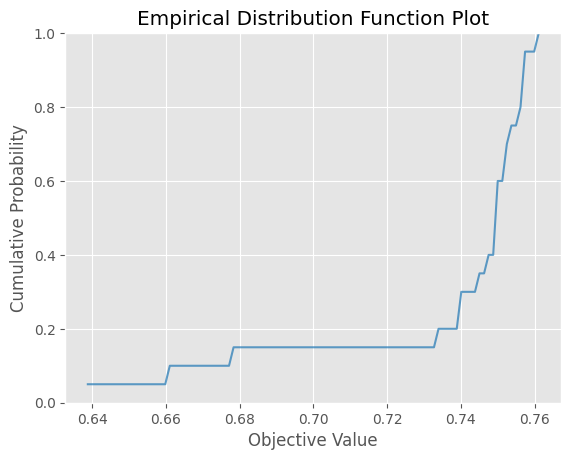

In [20]:
optuna.visualization.matplotlib.plot_edf([study])


### Classification

In [21]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        if isinstance(X_train, np.ndarray):
                columns = X_train.shape[1]
        else:
                columns = len(X_train.columns)
        
        model = LogisticRegression(C=study.best_params['C'],
                       tol=study.best_params['tol'],
                       class_weight="balanced",
                       solver=study.best_params['solver'],
                       max_iter=study.best_params['max_iter'],
                       random_state=42)

        if sel_method == "Boruta":
                sel_method = "Boruta" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": columns,
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [22]:
scaler_t = StandardScaler()
X_train_missForest_t = scaler_t.fit_transform(X_train_missForest_t)
X_test_missForest_t = scaler_t.transform(X_test_missForest_t)

In [23]:
trained_lg_n, metrics_lg_n = run_model("Logistic Regression", "Complete", X_train_missForest_t, y_train)
trained_lg_t, metrics_lg_t = run_model("Logistic Regression", "Boruta", X_train_t, y_train)

In [24]:
validation_df = pd.concat([metrics_lg_n, metrics_lg_t])
validation_df_report = validation_df.set_index(["Classifier", "Metric", "Feature Selection", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Classifier          Metric            Feature Selection Fit Time Total Features               
Logistic Regression balanced_accuracy Complete          0.031    22                   0.784   
                                      Boruta            0.015    9                    0.770   

                                                                                 Std Train  \
Classifier          Metric            Feature Selection Fit Time Total Features              
Logistic Regression balanced_accuracy Complete          0.031    22                  0.014   
                                      Boruta            0.015    9                   0.010   

                                                                                 Mean Test  \
Classifier          Metric            Feature Selection Fit Time Total Features              
Logistic Regression balanced_accuracy Complete          0.031    22                  0.741   
                                      Boruta            0.015    9                   0.761   

                                                                                 Std Test  
Classifier          Metric            Feature Selection Fit Time Total Features            
Logistic Regression balanced_accuracy Complete          0.031    22                 0.086  
                                      Boruta            0.015    9                  0.064

In [25]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        if isinstance(X_train, np.ndarray):
                columns = X_train.shape[1]
        else:
                columns = len(X_train.columns)
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="weighted"), 3),
                "recall": round(recall_score(y_train, pred_train, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_train, pred_train, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_train, pred_train_proba, average="weighted", multi_class="ovr"),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="weighted"), 3),
                "recall": round(recall_score(y_test, pred_test, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_test, pred_test, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_test, pred_test_proba, average="weighted", multi_class="ovr"),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [30]:
results = "filtered"
prediction_df_report = None

if results == "all":

    pred_ngb_n = eval_model("Logitic Regression", trained_lg_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_ngb_t = eval_model("Logitic Regression", trained_lg_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_ngb_n, pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":

    pred_ngb_t = eval_model("NGBoost", trained_lg_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier Classification Time Total Features Metric                             
Boruta            NGBoost    0.545               9              accuracy                   0.765   
                                                                balanced_accuracy          0.776   
                                                                precision                  0.762   
                                                                recall                     0.765   
                                                                f1_weighted                0.761   
                                                                roc_auc_ovr_weighted       0.899   

                                                                                      Test data  
Feature Selection Classifier Classification Time Total Features Metric                           
Boruta            NGBoost    0.545               9              accuracy                  0.709  
                                                                balanced_accuracy         0.729  
                                                                precision                 0.705  
                                                                recall                    0.709  
                                                                f1_weighted               0.699  
                                                                roc_auc_ovr_weighted      0.837

### Export model

In [27]:
trained_lg_t

LogisticRegression(C=0.18751437186365183, class_weight='balanced', max_iter=423,
                   random_state=42, tol=0.00018067941080463672)

In [28]:
import pickle

# Save the trained model using pickle
with open("logit_model.pkl", "wb") as file:
    pickle.dump(trained_lg_t, file)

print("Logistic model saved successfully!")

Logistic model saved successfully!


In [29]:
# Load the saved model using pickle
with open("logit_model.pkl", "rb") as file:
    loaded_model_ngb = pickle.load(file)